## Objective

#### NLP sentiment classification on news headlines
Using APIs or a little webscraping to harvest some new test data that you will manually label the new headlines as negative/positive and then see how your model does on those headlines.

#### Dataset:
[Sentiment Analysis for Financial News](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news)

## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLTK - Stopwords:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models.doc2vec import TaggedDocument
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

#to see the entire column width:
pd.set_option('display.max_colwidth', -1)

In [2]:
import tensorflow as tf
tf.__version__

'2.3.1'

### Imoport Data

In [3]:
df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df.head())
print("Shape:", df.shape, "\n\n")
print(df.info())

Sentiment  \
0  positive   
1  negative   
2  neutral    
3  neutral    
4  neutral    

                                                                                                                                                                                                              Headline  
0  And the broker repeated its ` buy ' rating , based on expectations that current restructuring will lead to a clear improvement in performance in Europe in 2007 .                                                    
1  SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANGE RELEASE OCTOBER 14 , 2008 AT 2:45 PM The Company updates its full year outlook and estimates its results to remain at loss for the full year .                       
2  The group posted net sales of 35.3 mln euro $ 46.5 mln and an operating profit of 760,000 euro $ 1.0 mln in 2005 .                                                                                                   
3  According to Ultrascan , with a software acquired from crackers , it has managed to change the mobile phone in a way that the phone was able to get hold of a one-time password sent by a bank via a text message .  
4  This organization will assume the responsibility for operations in Russia .

Shape: (4846, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Headline   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [4]:
# Look at the instances of each sentiment
df.Sentiment.value_counts()

neutral     2879
positive    1363
negative    604 
Name: Sentiment, dtype: int64

#### Visualize the data

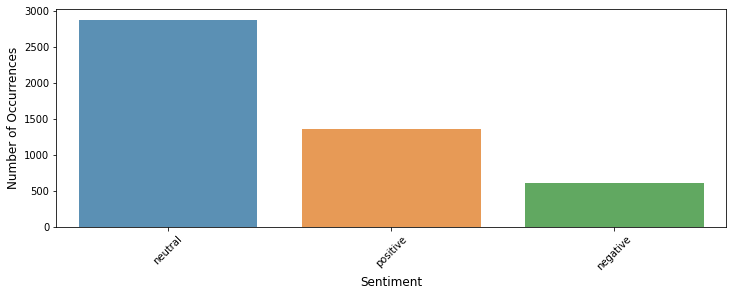

In [5]:
cnt_pro = df['Sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.show();

### Clean the Data

In [6]:
# Convert the string in the 'Sentiment' column to numeric form
Sentiment = {'positive': 0, 'neutral': 1, 'negative': 2} 

#df[Sentiment]=df[Sentiment].map(Sentiment)

In [7]:
# traversing through Sentiment column and writing values where key matches
df.Sentiment = [Sentiment[item] for item in df.Sentiment] 
df.head(10)

Sentiment  \
0  0           
1  2           
2  1           
3  1           
4  1           
5  0           
6  1           
7  0           
8  0           
9  1           

                                                                                                                                                                                                              Headline  
0  And the broker repeated its ` buy ' rating , based on expectations that current restructuring will lead to a clear improvement in performance in Europe in 2007 .                                                    
1  SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANGE RELEASE OCTOBER 14 , 2008 AT 2:45 PM The Company updates its full year outlook and estimates its results to remain at loss for the full year .                       
2  The group posted net sales of 35.3 mln euro $ 46.5 mln and an operating profit of 760,000 euro $ 1.0 mln in 2005 .                                                                                                   
3  According to Ultrascan , with a software acquired from crackers , it has managed to change the mobile phone in a way that the phone was able to get hold of a one-time password sent by a bank via a text message .  
4  This organization will assume the responsibility for operations in Russia .                                                                                                                                          
5  Its board of directors will propose a dividend of EUR0 .12 per share for 2010 , up from the EUR0 .08 per share paid in 2009 .                                                                                        
6  CapMan has six investment areas CapMan Buyout , CapMan Technology , CapMan Life Science , CapMan Russia , CapMan Public Market and CapMan Real Estate , and each of them has a dedicated team and funds .            
7  A new Kveyt light variety of Suomalainen Pekoni marketed under the Atria brand name is now available to consumers in Finland .                                                                                       
8  firm 28 October 2009 - Finnish lifting equipment maker Konecranes Oyj HEL : KCR1V said today it acquired US Machine Tool Solutions Unlimited in Cincinnati , Ohio , for an undisclosed sum .                         
9  KONE is listed on the Nordic Exchange in Helsinki .

#### Stopwords:
Remove words from strings that have no unique information ('is','an','the).

In [8]:
#nltk.download('stopwords')

stop = set(stopwords.words('english'))
stop.add("'s")
for item in string.punctuation:
    stop.add (item)
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Headline'] = df['Headline'].map(remove_stopwords)

In [9]:
#make a new column for clean headlines and then other columns for different version of data

In [10]:
#check
df.head()

Sentiment  \
0  0           
1  2           
2  1           
3  1           
4  1           

                                                                                                                                                    Headline  
0  broker repeated buy rating based expectations current restructuring lead clear improvement performance europe 2007                                         
1  ssh communications security corp stock exchange release october 14 2008 2:45 pm company updates full year outlook estimates results remain loss full year  
2  group posted net sales 35.3 mln euro 46.5 mln operating profit 760,000 euro 1.0 mln 2005                                                                   
3  according ultrascan software acquired crackers managed change mobile phone way phone able get hold one-time password sent bank via text message            
4  organization assume responsibility operations russia

#### Lemmatization:
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. [Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)

In [11]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return " ".join(text)

df['Headline_Lemma'] = df['Headline'].map(lemmatize)

In [13]:
#check
df.head()

Sentiment  \
0  0           
1  2           
2  1           
3  1           
4  1           

                                                                                                                                                    Headline  \
0  broker repeated buy rating based expectations current restructuring lead clear improvement performance europe 2007                                          
1  ssh communications security corp stock exchange release october 14 2008 2:45 pm company updates full year outlook estimates results remain loss full year   
2  group posted net sales 35.3 mln euro 46.5 mln operating profit 760,000 euro 1.0 mln 2005                                                                    
3  according ultrascan software acquired crackers managed change mobile phone way phone able get hold one-time password sent bank via text message             
4  organization assume responsibility operations russia                                                                                                        

                                                                                                                                          Headline_Lemma  
0  broker repeat buy rating base expectation current restructuring lead clear improvement performance europe 2007                                         
1  ssh communication security corp stock exchange release october 14 2008 2:45 pm company update full year outlook estimate result remain loss full year  
2  group post net sale 35.3 mln euro 46.5 mln operating profit 760,000 euro 1.0 mln 2005                                                                  
3  accord ultrascan software acquire cracker manage change mobile phone way phone able get hold one-time password sent bank via text message              
4  organization assume responsibility operation russia

WordCloud to see the commonly used words

In [14]:
#!pip install wordcloud

In [15]:
# Separating out the categories
# pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
# neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]

In [16]:
def wordcloud(dataset):
    plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
    wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1000, 
                          height = 600,
                          collocations=False).generate(" ".join(dataset))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show();

def show_wordclouds(column='Headline'):
    # Separating out the categories
    pos = df[column][df.Sentiment[df.Sentiment== 1].index]
    neg = df[column][df.Sentiment[df.Sentiment== 0].index]
    print ('Positive Sentiment Wordcloud:')
    wordcloud(pos)
    
    print ('Negative Sentiment Wordcloud:')
    wordcloud(neg)
    

Positive Sentiment Wordcloud:


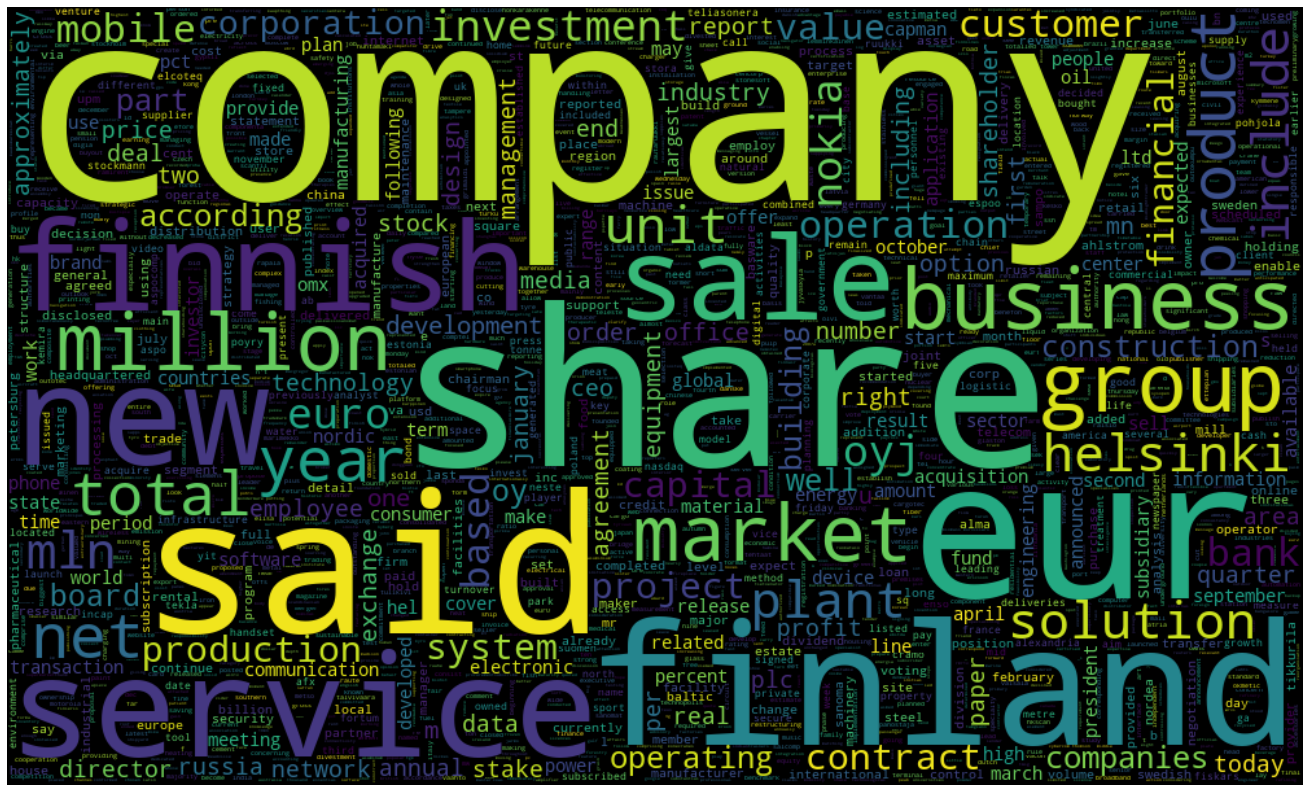

Negative Sentiment Wordcloud:


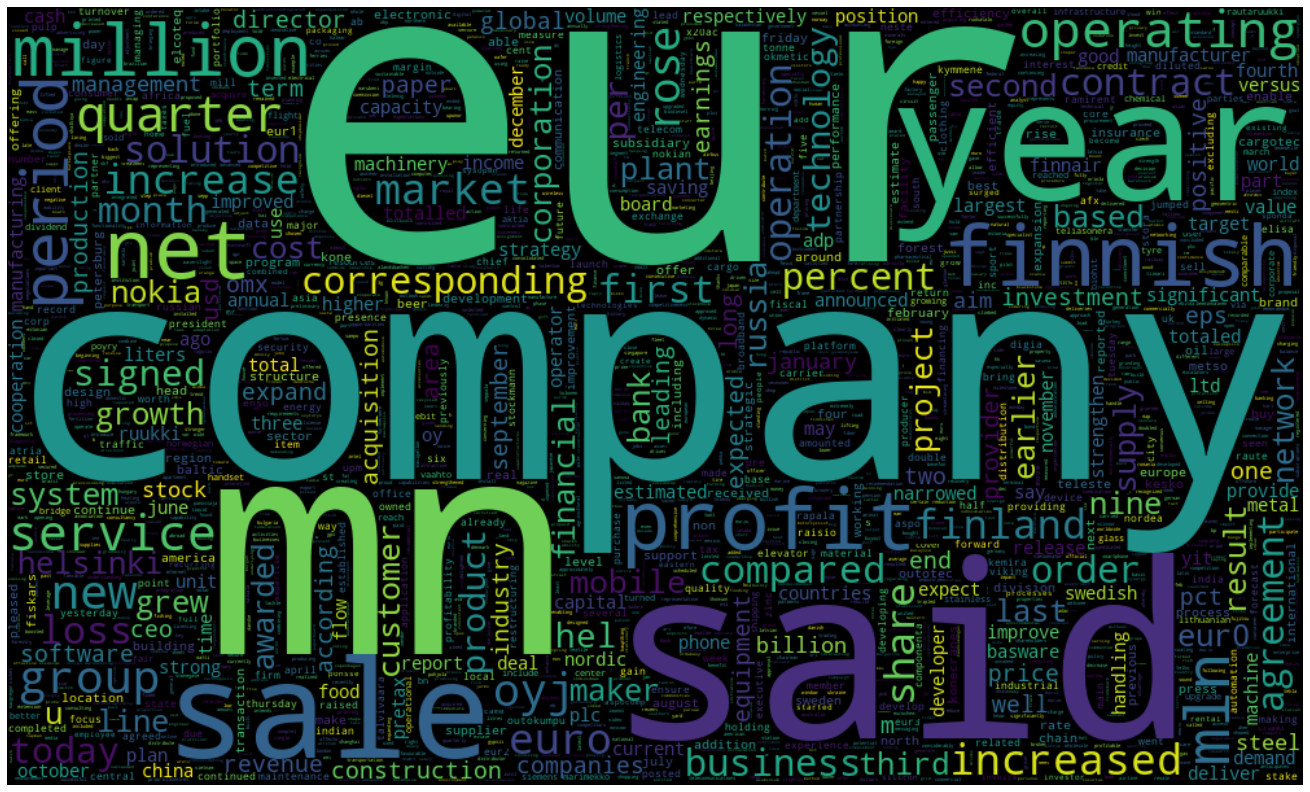

In [17]:
show_wordclouds()

Positive Sentiment Wordcloud:


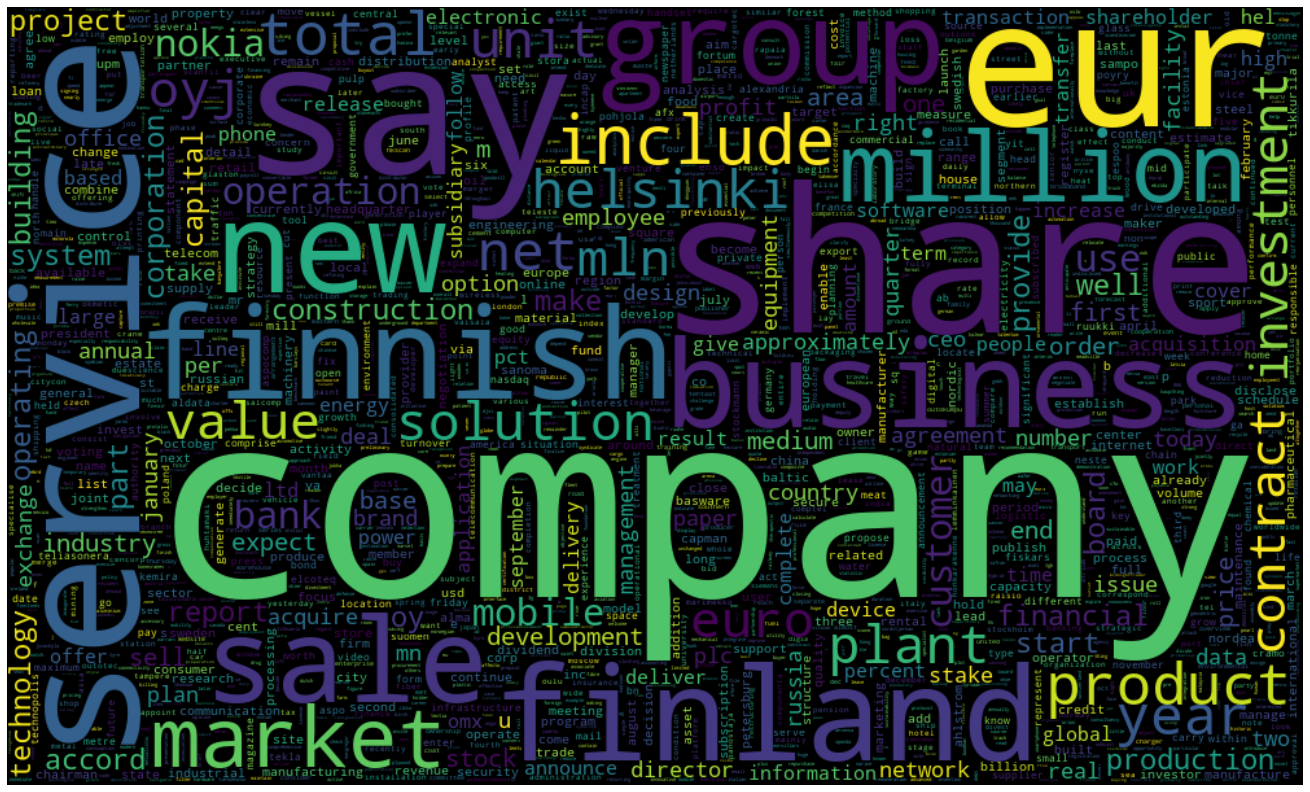

Negative Sentiment Wordcloud:


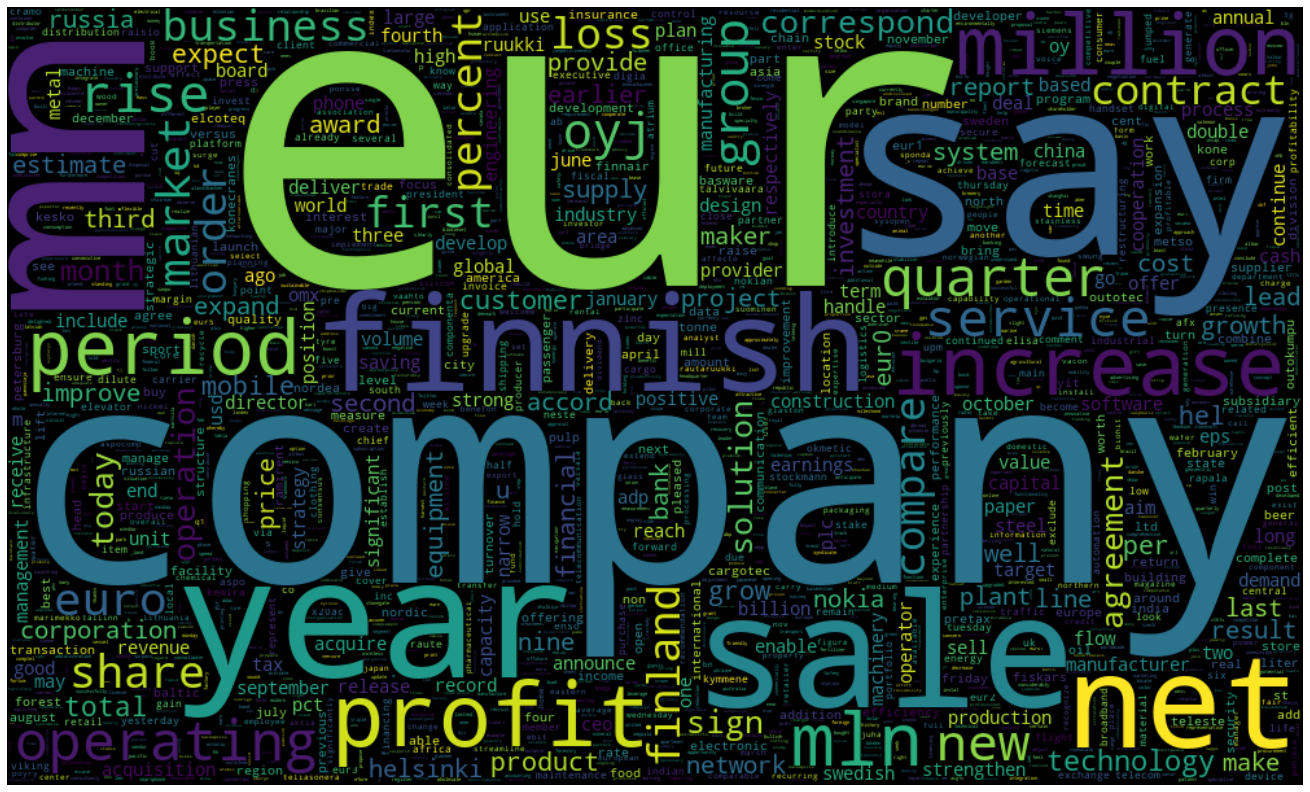

In [18]:
show_wordclouds('Headline_Lemma')

Process the text to convert text to lower-case strip punctuations and symbols etc.

In [19]:
from bs4 import BeautifulSoup
import re

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text


df['Headline_soup'] = df['Headline_Lemma'].apply(cleanText)


In [20]:
df.head()

Sentiment  \
0  0           
1  2           
2  1           
3  1           
4  1           

                                                                                                                                                    Headline  \
0  broker repeated buy rating based expectations current restructuring lead clear improvement performance europe 2007                                          
1  ssh communications security corp stock exchange release october 14 2008 2:45 pm company updates full year outlook estimates results remain loss full year   
2  group posted net sales 35.3 mln euro 46.5 mln operating profit 760,000 euro 1.0 mln 2005                                                                    
3  according ultrascan software acquired crackers managed change mobile phone way phone able get hold one-time password sent bank via text message             
4  organization assume responsibility operations russia                                                                                                        

                                                                                                                                          Headline_Lemma  \
0  broker repeat buy rating base expectation current restructuring lead clear improvement performance europe 2007                                          
1  ssh communication security corp stock exchange release october 14 2008 2:45 pm company update full year outlook estimate result remain loss full year   
2  group post net sale 35.3 mln euro 46.5 mln operating profit 760,000 euro 1.0 mln 2005                                                                   
3  accord ultrascan software acquire cracker manage change mobile phone way phone able get hold one-time password sent bank via text message               
4  organization assume responsibility operation russia                                                                                                     

                                                                                                                                          Headline_soup  
0  broker repeat buy rating base epectation current restructuring lead clear improvement performance europe 2007                                         
1  ssh communication security corp stock echange release october 14 2008 2:45 pm company update full year outlook estimate result remain loss full year  
2  group post net sale 35.3 mln euro 46.5 mln operating profit 760,000 euro 1.0 mln 2005                                                                 
3  accord ultrascan software acquire cracker manage change mobile phone way phone able get hold one-time password sent bank via tet message              
4  organization assume responsibility operation russia

#### Counter

In [21]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [22]:
text = df.Headline_Lemma
counter = counter_word(text)

In [23]:
len(counter)

10088

In [24]:
num_words = len(counter)

### Train/Test Split

In [25]:
headlines = []
labels = []

for row in range(len(df)):
    headlines.append(df['Headline_soup'][row])
    labels.append(df['Sentiment'][row])

In [26]:
training_headlines, testing_headlines, training_labels, testing_labels = train_test_split(headlines, labels, test_size=0.2 , random_state=42)

In [27]:
# # Setting the training ratio
# training_size = int(df.shape[0] * .8) 

# # Train Test Split:
# # Already shuffled, so we're good to go
# training_headlines = headlines[0:training_size]
# testing_headlines = headlines[training_size:]
# training_labels = labels[0:training_size]
# testing_labels = labels[training_size:]

In [28]:
# Checking on a few of the headlines:
display(training_headlines[:3])
display(training_labels[:3])

['fi acquisition price amount nok 70 approimately eur 8.7 million additional price nok 15 eur 1.8 million maimum',
 'z. bavelloni long-standing md dino bavelloni retire end 2005',
 'helsinki af salcomp mobile phone charger manufacturer say appoint markku hangasjarvi new ceo follow resignation mat eriksson']

[1, 1, 1]

### Tokenizer 
Tokenizing involoves splitting sentances and words from the body of the text
The use of a tokenizer creates a number coded to each word thereby allowing 
the neural network to build patterns and learn meaning.

In [29]:
# function to tokenize text

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

In [30]:
# apply the splits to the tokenizer

# Gensim is a Python library for topic modeling, document indexing and Similarity retrieval with large corpora.
#[Gensim](https://pypi.org/project/gensim/)
# train_tagged = train.apply(
#     lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)
# test_tagged = test.apply(
#     lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)

In [31]:
# set the maximum words to be used
max_features = 500000

# set the maximum words in each headline
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(training_headlines)
X_train = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(X_train)
print('Found %s unique tokens.' % len(training_padded))


Found 3876 unique tokens.


In [32]:
# check the shape of data tensor:
X_test = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(X_test, maxlen=max_sequence_length)
print('Shape of data tensor:', testing_padded.shape)

Shape of data tensor: (970, 50)


In [33]:
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [34]:
# # Initializing the fitting the tokenizer:
# tokenizer = Tokenizer(num_words = num_words, oov_token = oov_tok)
# tokenizer.fit_on_texts(training_headlines)
# # Initializing the Word Index:
# word_index = tokenizer.word_index
# # Padding and Sequencing the Training Set:
# training_sequences = tokenizer.texts_to_sequences(training_headlines)
# training_padded = pad_sequences(training_sequences, maxlen = max_length,
#                                padding = padding_type, 
#                                truncating = trunc_type)
# # Padding and Sequencing the Testing Set:
# testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
# testing_padded = pad_sequences(testing_sequences, maxlen = max_length, 
#                                padding = padding_type, 
#                                truncating = trunc_type)


In [45]:
# # Switch to Numpy Array
# # Necessary for the ANN to read the data
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [46]:
print ('Padded and Tokenized Headline:\n', training_padded[3])
print ('\nThe actual headline:\n', training_headlines[3])
print ('\nLabel:\n', training_labels[3])

Padded and Tokenized Headline:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  279  300  118   29  673  309   12  770    1 3720]

The actual headline:
 stora enso third-quarter pre-ta profit double eur 197mn

Label:
 0


In [47]:
# train
#train_tagged.values

### Model 1 (Hidden Layer)

In [ ]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=64))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(1, activation='sigmoid'))

# Slower learning rate worked better as it kept the learning more stable
#opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer='adam', 
              metrics=['accuracy']) # Orig code

In [49]:
# num_epochs = 50
# # After 5 epochs of validation loss not improving, the model will stop.
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# history = model.fit(training_padded, training_labels, 
#                     epochs=num_epochs,
#                     batch_size = 10,
#                     validation_data=(testing_padded, testing_labels), 
#                     verbose= 1, callbacks=[es])

### Functions for Model Evaluation:

In [50]:
def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def model_metrics(model):
    train_acc = model.evaluate(training_padded, training_labels, verbose=0)
    test_acc = model.evaluate(testing_padded, testing_labels, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))
    
# Made up some easy headlines to see if the ANN works
def easy_headlines():
    sentence = ["stock rise rapid for tesla", 
                "apple factory shut down, lay off hundred employee",
                "average day of return for microsoft"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))
    
# Random headlines from NYT Business  (post stopword removal and lemmatization) 
# This may be a bit trickier for the network
def harder_headlines():
    sentence = ["snowflake more  double  debut  wall street embrace tech ipos", 
                "europe economic revival imperil raising the specter grind downturn",
                "fed debate next step after shifting approach to rate setting"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))

def test_headlines():
    print('Easier Headlines:')
    easy_headlines()
    print ('\n')
    print ('Realistic Headlines:')
    harder_headlines()

In [51]:
#model_metrics(model)

In [52]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[[0.50008297]
  [0.49529508]
  [0.4972838 ]
  [0.501326  ]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]
  [0.50207835]]

 [[0.49905047]
  [0.50117016]
  [0.500131  ]
  [0.4999572 ]
  [0.49699998]
  [0.5008023 ]
  [0.498033  ]
  [0.4952267

### Model 2 (LSTM):

In [55]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [56]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 24,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks = [es])

Epoch 1/50
162/162 [==============================] - 10s 61ms/step - loss: 0.4089 - accuracy: 0.5962 - val_loss: 0.2852 - val_accuracy: 0.6351
Epoch 2/50
162/162 [==============================] - 9s 56ms/step - loss: -0.9034 - accuracy: 0.6692 - val_loss: -0.6275 - val_accuracy: 0.6258
Epoch 3/50
162/162 [==============================] - 9s 58ms/step - loss: -10.0919 - accuracy: 0.7257 - val_loss: -3.6966 - val_accuracy: 0.6186
Epoch 4/50
162/162 [==============================] - 9s 58ms/step - loss: -29.2347 - accuracy: 0.7263 - val_loss: -12.1181 - val_accuracy: 0.5804
Epoch 5/50
162/162 [==============================] - 10s 60ms/step - loss: -53.4948 - accuracy: 0.7487 - val_loss: -18.7958 - val_accuracy: 0.6320
Epoch 6/50
162/162 [==============================] - 10s 61ms/step - loss: -92.2000 - accuracy: 0.7593 - val_loss: -32.4299 - val_accuracy: 0.6371
Epoch 7/50
162/162 [==============================] - 10s 63ms/step - loss: -123.6093 - accuracy: 0.7590 - val_loss: -51.7

KeyboardInterrupt: 

In [ ]:
model_metrics(model)

In [ ]:
model_eval(history)

In [71]:
from tensorflow.keras.utils import to_categorical
training_labels_ohe = to_categorical(training_labels)
testing_labels_ohe = to_categorical(testing_labels)

testing_labels_ohe[0]

array([0., 1., 0.], dtype=float32)

In [68]:
embedding_dim = 32

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [70]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels_ohe, 
                    epochs=num_epochs,
                    batch_size = 32,
                    validation_data=(testing_padded, testing_labels_ohe), 
                    #validation_split = .1,
                    verbose= 1, callbacks = [es])

Epoch 1/50
122/122 [==============================] - ETA: 0s - loss: 0.7097 - accuracy: 0.6806

ValueError: in user code:

    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 test_function  *
        return step_function(self, iterator)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1208 run_step  **
        outputs = model.test_step(data)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1177 test_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/ArashPeimani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


In [ ]:
model_eval(history) #seperate val and loss